Подключение файла Essentials, содержащего все необходимые шаблоны

In [461]:
import sys
sys.path.append("..")

import Essentials
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from abc import ABC, abstractmethod
from sklearn.model_selection import cross_val_score
import numpy as np


Подключение необходимых для алгоритма библиотек, numpy понадобится всем

In [462]:
import numpy as np

from sklearn.preprocessing import StandardScaler

In [463]:
a = np.load('C:\\Users\\misha\\PLSSVD\\Data_Average.npz', allow_pickle=True)

In [464]:
x1 = a['X_test_1']
x2 = a['X_train_1']

y1 = a['Y_test_1']
y2 = a['Y_train_1']

In [465]:
timestamp1 = y1[:, 1]
timestamp2 = y2[:, 1]

y1 = y1[:, 0].reshape(len(y1), 1)
y1 = y1.astype(np.float64)
y2 = y2[:, 0].reshape(len(y2), 1)
y2 = y2.astype(np.float64)

C:\Users\misha\AppData\Local\Temp\ipykernel_7520\3146428066.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = y1.astype(np.float64)
C:\Users\misha\AppData\Local\Temp\ipykernel_7520\3146428066.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y2 = y2.astype(np.float64)


In [466]:
y1.shape

(74, 1)

In [467]:
x1.shape

(74, 96)

In [468]:
class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, x_train, y_train, n_components=2):  # По умолчанию используем 2 компонента
        super().__init__('PLSSVDSoftSensor')  # Имя сенсора задаем внутри конструктора
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.model = PLSRegression(n_components=n_components)
        self.coefficients = None
        self.test_score = None  # Для хранения R^2 на тестовых данных
        self.train(x_train, y_train)

    def preprocessing(self, x):
        return self.x_scaler.transform(x)

    def postprocessing(self, y):
        return self.y_scaler.inverse_transform(y)

    def evaluate_model(self, x):
        x_scaled = self.preprocessing(x)
        y_pred = self.model.predict(x_scaled)
        return y_pred

    def train(self, x_train, y_train, max_components=10):
        x_train_scaled = self.x_scaler.fit_transform(x_train)
        y_train_scaled = self.y_scaler.fit_transform(y_train)
        
        # Поиск оптимального количества компонентов с использованием кросс-валидации
        best_score = -np.inf
        best_n_components = 0
        for n_components in range(1, max_components + 1):
            model = PLSRegression(n_components=n_components)
            scores = cross_val_score(model, x_train_scaled, y_train_scaled, cv=3, scoring='r2')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_n_components = n_components
        
        # Обучение модели с оптимальным количеством компонентов
        self.model = PLSRegression(n_components=best_n_components)
        self.model.fit(x_train_scaled, y_train_scaled)
        self.coefficients = self.model.coef_
        self.n_components = best_n_components  # Сохраняем оптимальное количество компонентов
        self.best_cv_score = best_score  # Сохраняем лучший средний R^2 кросс-валидации

    def test(self, x_test, y_test):
        x_test_scaled = self.x_scaler.transform(x_test)
        y_test_scaled = self.y_scaler.transform(y_test)
        self.test_score = self.model.score(x_test_scaled, y_test_scaled)  # Вычисляем R^2 на тестовых данных

    def __str__(self):
        coefs_str = ", ".join([f"{coef:.3f}" for coef in self.coefficients.ravel()])
        return (f"Модель PLSSVD с {self.model.n_components} компонентами (оптимальное количество компонентов: {self.n_components}).\n"
                f"Коэффициенты линейной регрессии: {coefs_str}\n"
                f"Средний коэффициент детерминации (R^2) на кросс-валидации: {self.best_cv_score:.3f}\n"
                f"Коэффициент детерминации (R^2) на тестовых данных: {self.test_score:.3f}" if self.test_score is not None else "Тестовые данные не были предоставлены.")

In [469]:
sensor = PLSSVDSoftSensor(x2, y2)

In [470]:
sensor.test(x1, y1)

In [471]:
print(sensor)

Модель PLSSVD с 2 компонентами (оптимальное количество компонентов: 2).
Коэффициенты линейной регрессии: 0.024, 0.011, -0.023, 0.013, 0.015, -0.008, 0.001, 0.013, -0.016, 0.006, 0.013, -0.022, 0.032, 0.007, 0.025, 0.009, 0.021, 0.018, -0.034, -0.014, -0.003, -0.039, 0.032, 0.033, 0.000, 0.033, -0.040, 0.020, -0.061, -0.028, -0.019, 0.003, 0.009, 0.024, -0.015, 0.034, -0.048, 0.033, 0.011, -0.027, -0.027, -0.012, 0.011, 0.023, 0.018, 0.007, 0.008, 0.023, 0.016, 0.015, 0.014, 0.016, 0.019, 0.016, 0.019, 0.017, 0.021, -0.021, 0.056, 0.009, 0.007, 0.013, -0.016, 0.003, -0.018, 0.040, -0.030, -0.008, -0.013, 0.017, 0.040, 0.005, -0.003, -0.032, -0.026, -0.004, -0.004, -0.010, 0.009, 0.003, 0.029, 0.043, 0.027, -0.034, 0.011, 0.022, 0.021, -0.002, 0.013, 0.024, -0.012, -0.011, 0.030, -0.011, 0.014, 0.020
Средний коэффициент детерминации (R^2) на кросс-валидации: 0.474
Коэффициент детерминации (R^2) на тестовых данных: -23.307


Создание экземпляра метрики, достаточно одного для тестирования

In [472]:
metric = Essentials.R2Metric()

In [473]:
test_visual = Essentials.Visualizer(x1, y1, timestamp1, [metric], 'Test SoftSensor R2 metric')

In [474]:
sensor.test(x1,y1,metric)

TypeError: PLSSVDSoftSensor.test() takes 3 positional arguments but 4 were given

                  Coefficient of determination
PLSSVDSoftSensor                 -16537.584508


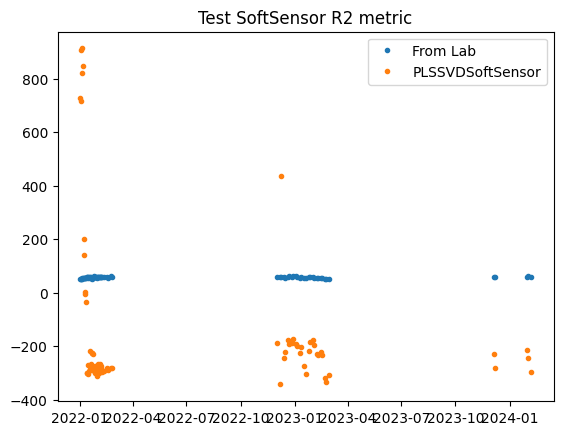

In [ ]:
test_visual.visualize([Test_sensor_1])